In [1]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("../input/"))
import cv2 
import PIL 
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil

import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu
from keras.optimizers import Adam, rmsprop, RMSprop
from keras.layers import BatchNormalization

['xception', 'resnet50', 'aptos2019-blindness-detection', 'vgg16']


Using TensorFlow backend.


In [2]:
from tqdm import tqdm

In [3]:
SEED=7
np.random.seed(SEED) 
set_random_seed(SEED)

In [4]:
df_train=pd.read_csv("../input/aptos2019-blindness-detection/train.csv") 
df_test=pd.read_csv("../input/aptos2019-blindness-detection/test.csv")

In [5]:
IMG_DIM=299 #512
BATCH_SIZE = 32
CHANNEL_SIZE=3
NUM_EPOCHS=12
FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_CLASSES = df_train['diagnosis'].nunique()

CLASSS={0:"No DR",1:"Mild",2:"Moderate",3:"Severe",4:"Proliferative DR"}

In [6]:
df_train.columns, NUM_CLASSES

(Index(['id_code', 'diagnosis'], dtype='object'), 5)

In [7]:
x_train,x_test,y_train,y_test=train_test_split(df_train.id_code, df_train.diagnosis, test_size=0.2, random_state =SEED, stratify=df_train.diagnosis)
# x_train.shape,y_train.shape,x_test.shape,y_test.shape

In [8]:
print(x_train)

1725    7a06ea127e02
10      00cc2b75cddd
3245    e1ab92228e60
2163    9858cc2ae073
1160    51405d042000
2279    a06b353e7bed
647     2da82d14e1b7
1237    55eb405ec71e
1494    68987fb159ab
1991    8bdb891661a8
2689    b9d0b83d70c3
1915    8714d17bb6da
1315    5b5b80a3edee
3416    ed648b9bcd95
133     09f6ab477654
1975    8ab8d9b3ce3f
2160    9837048b85dc
726     342edf9b889d
323     1864d3411143
2634    b70cb31b9abb
1176    51da6aebba8f
2040    8f2996b8d855
2461    aafb0c944f14
787     384e6c915722
1585    6f3b62e5b7f5
732     3486f7096276
2696    ba4d2c4b3039
3188    de18071c36e6
1082    4cf4d528c08e
2379    a6731dd737af
            ...     
1745    7b49041cbf17
568     283c3aeba594
1599    709784f7fcc2
1976    8ac0c44bbf24
1493    6889bc64ab09
450     1faf8664816c
2467    ab50123abadb
1049    4ad6109706e8
313     17d997fe1090
2922    cadde4030858
2315    a2163f0c2af5
3045    d364423ec6f9
2819    c3789c1dab96
2687    b9bc81fcb075
198     0eb52045349f
2546    b0619ca93a5f
2777    bfe46

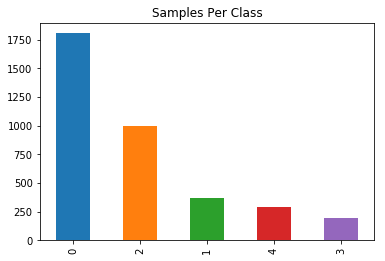

In [9]:
df_train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Samples Per Class');

(2136, 3216, 3)


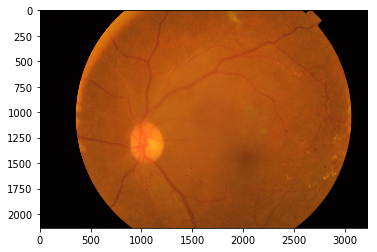

(299, 299, 3)


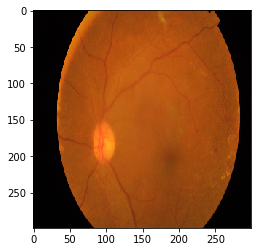

In [10]:
# Size and shape of images
# import random
# sample=random.choice(df_train)
# print(sample)
imgPath=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png"
# lower-right, this still looks not so severe, can be class3
img=cv2.imread(imgPath)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
img =cv2.resize(img,(IMG_DIM,IMG_DIM))
print(img.shape)
plt.imshow(img)

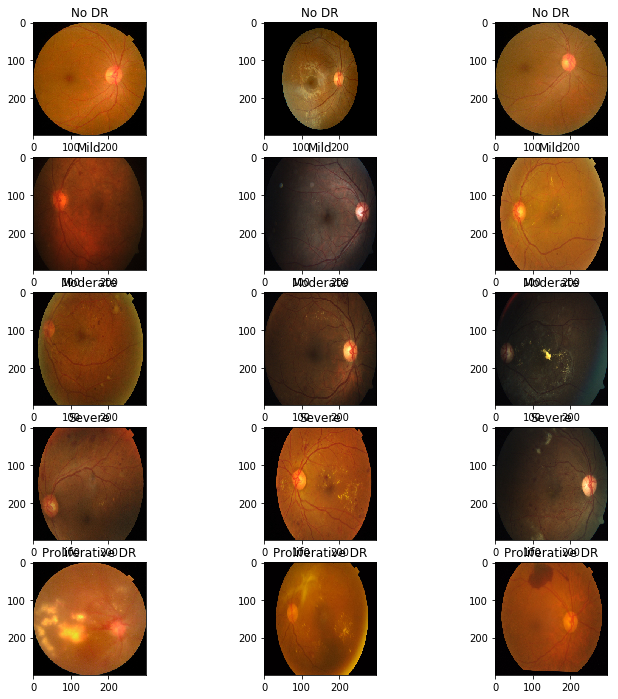

In [11]:
figure=plt.figure(figsize=(20,12))
for target_class in (y_train.unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(3, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img =cv2.resize(img,(IMG_DIM,IMG_DIM))
        plt.imshow(img)
        ax.set_title(CLASSS[target_class])
#     plt.show()

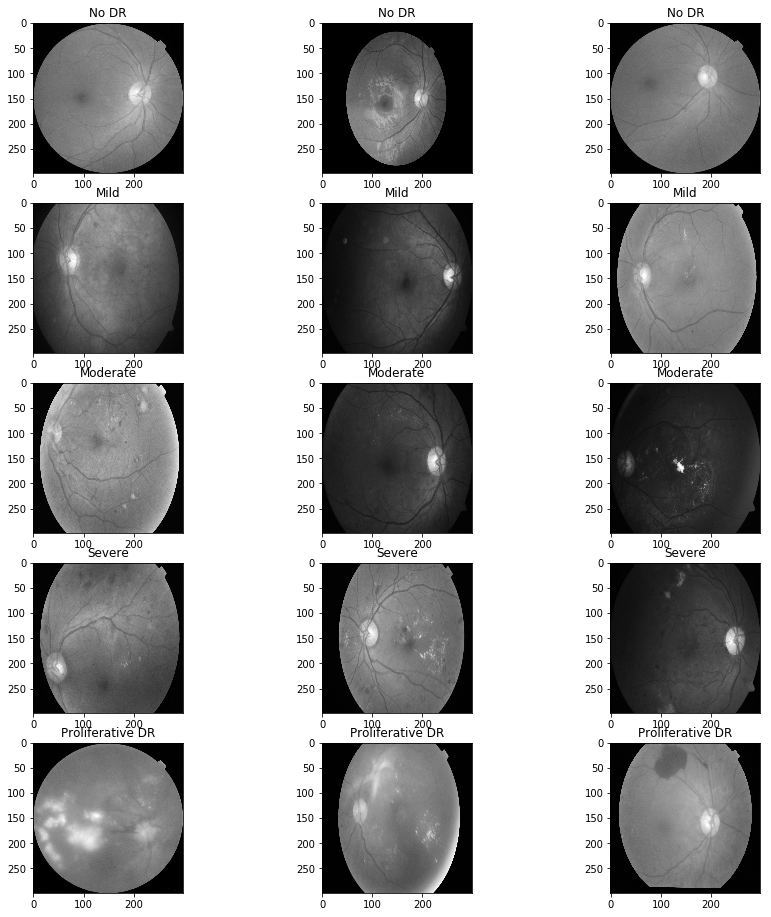

In [12]:
figure=plt.figure(figsize=(25,16))
for target_class in (y_train.unique()): 
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(3, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img =cv2.resize(img,(IMG_DIM,IMG_DIM))
        plt.imshow(img,cmap='gray')
        ax.set_title(CLASSS[target_class])
#     plt.show()

(2136, 3216)
2136 3216


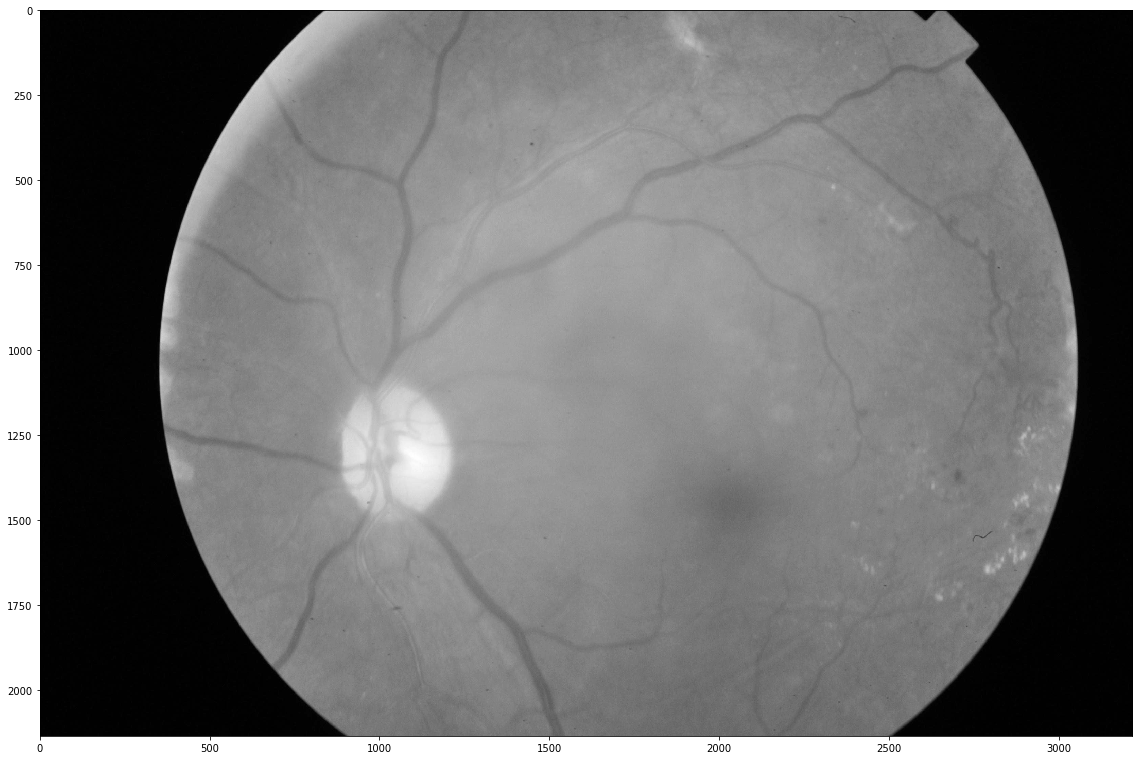

In [13]:
dpi =80 
imgPath=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png"
# lower-right, this still looks not so severe, can be class3
img=cv2.imread(imgPath)
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(img.shape)
height, width=img.shape
print(height, width)
SCALE=2
figSize=(width/float(dpi))/SCALE,(height/float(dpi))/SCALE
fig=plt.figure(figsize=figSize)
plt.imshow(img, cmap="gray")


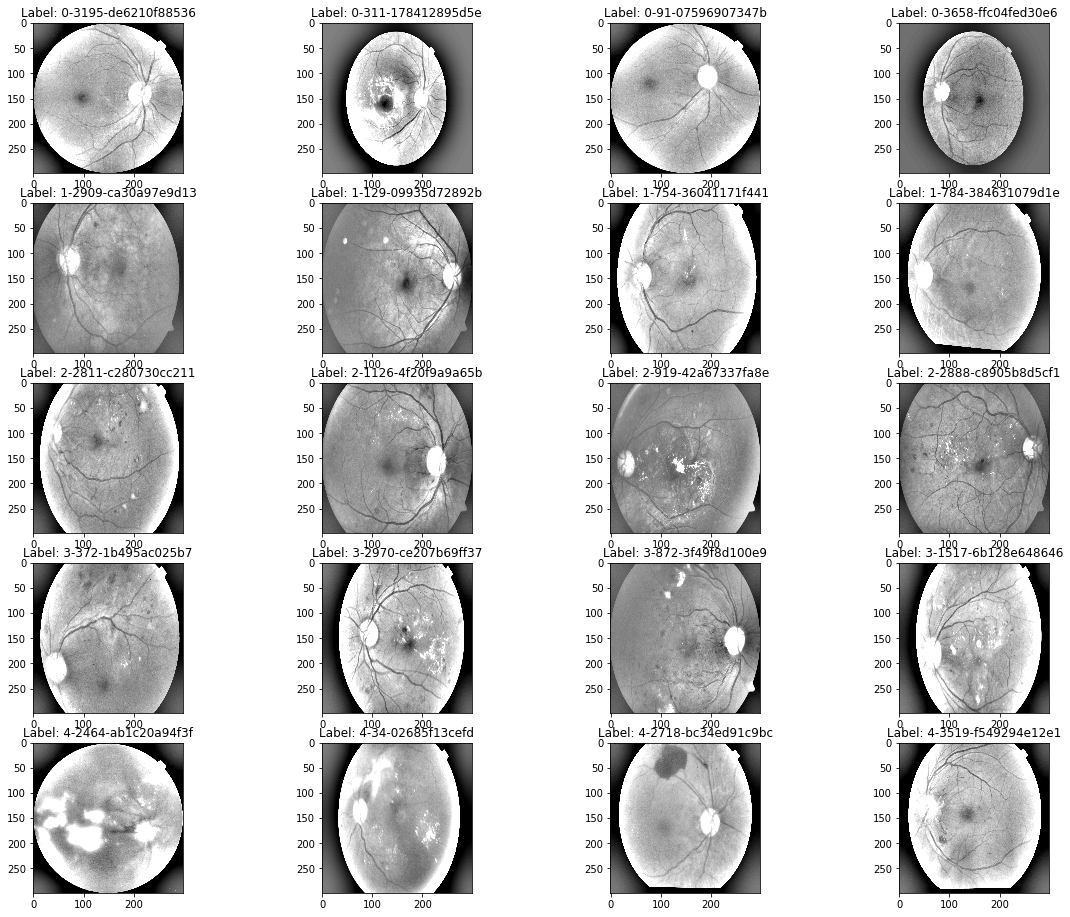

In [14]:
# Display some random images from Data Set with class categories. showig Gray image removing other channel and adding lighting to image.
figure=plt.figure(figsize=(25,16))
for target_class in (y_train.unique()):
#     print(CLASSS[target_class],target_class)
    for i, (idx, row ) in enumerate(df_train.loc[df_train.diagnosis==target_class].sample(4, random_state=SEED).iterrows()):
        ax= figure.add_subplot(5,5, target_class*5+i+1)
        imagefile=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png" 
        img=cv2.imread(imagefile)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img =cv2.resize(img,(IMG_DIM,IMG_DIM))
        img=cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), IMG_DIM/10),-4, 128)
        plt.imshow(img,cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (target_class, idx, row['id_code']) )
#     plt.show()

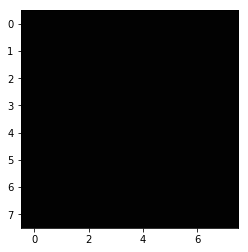

In [15]:
imgPath=f"../input/aptos2019-blindness-detection/train_images/cd54d022e37d.png"
img=cv2.imread(imgPath)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
x,y,w,h = cv2.boundingRect(cnt)
img = img[y:y+h,x:x+w]
plt.imshow(img)

In [16]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1] 
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1) 
    img=img[y:(y+dy), x:(x+dx), :] 
    return img
    
"""Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """  
def crop_generator(batches, crop_length):    
    while True:
        batch_x, batch_y=next(batches)
        batch_crops=np.zeros((batch_x.shape[0],crop_length,3))
        for i in range(batch_x.shape[0]):
            batch_crops[0]=random_crop(batch_x[i],(crop_length, crop_length))
        yield (batch_crops, batch_y)

In [17]:
print("available RAM:", psutil.virtual_memory())
gc.collect()
print("available RAM:", psutil.virtual_memory())

df_train.id_code=df_train.id_code.apply(lambda x: x+".png")
df_test.id_code=df_test.id_code.apply(lambda x: x+".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

available RAM: svmem(total=16831684608, available=15046692864, percent=10.6, used=1267523584, free=6529683456, active=7759933440, inactive=1766645760, buffers=574115840, cached=8460361728, shared=171073536, slab=661934080)
available RAM: svmem(total=16831684608, available=15047110656, percent=10.6, used=1267105792, free=6530076672, active=7759941632, inactive=1766662144, buffers=574124032, cached=8460378112, shared=171073536, slab=661975040)


In [18]:
train_datagen=image.ImageDataGenerator(rescale=1./255,validation_split=0.2,horizontal_flip=True)


In [19]:
train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="../input/aptos2019-blindness-detection/train_images/",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='training', 
                                                  shaffle=False,
                                                  seed=SEED,
                                                 )
valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                  directory="../input/aptos2019-blindness-detection/train_images/",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=BATCH_SIZE,
                                                  class_mode="categorical",
                                                  target_size=(IMG_DIM, IMG_DIM),
                                                  subset='validation',
                                                  shaffle=False,
                                                  seed=SEED
                                                 )
del x_train 
# # del x_test
del y_train
# del y_test
gc.collect()
#  color_mode= "grayscale",

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


14

In [20]:
eraly_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr  = ReduceLROnPlateau(monitor='val_loss',  min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6,  mode='auto', verbose=1)

In [21]:
NUB_TRAIN_STEPS=train_generator.n//train_generator.batch_size
NUB_VALID_STEPS=valid_generator.n//valid_generator.batch_size

NUB_TRAIN_STEPS, NUB_VALID_STEPS

(91, 22)

In [22]:
print(os.listdir("../input/"))


['xception', 'resnet50', 'aptos2019-blindness-detection', 'vgg16']


In [23]:
def create_resnet(img_dim,CHANNEL,n_class):
    input_tensor=Input(shape=(img_dim, img_dim,CHANNEL))
  
    base_model = Xception(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    x=GlobalAveragePooling2D()(base_model.output)
    x=Dropout(0.3)(x)
    x=Dense(1024, activation=relu)(x)
    x=Dropout(0.2)(x)
    x=Dense(512, activation=relu)(x)
    x=Dropout(0.2)(x)
    x=BatchNormalization()(x)
    output_layer=Dense(n_class,activation='softmax', name="Output_Layer")(x)
    model_resnet =Model(input_tensor, output_layer)
    
    return model_resnet
model_resnet=create_resnet(IMG_DIM,CHANNEL_SIZE, NUM_CLASSES)

In [24]:
for layers in model_resnet.layers:
    layers.trainable=True

In [25]:
lr = 1e-3
optimizer=rmsprop(lr=lr,decay=0.1)
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])
# model.summary()
gc.collect()

279

In [26]:
history=model_resnet.fit_generator(generator=train_generator,
                           steps_per_epoch=NUB_TRAIN_STEPS,
                           validation_data=valid_generator,
                           validation_steps=NUB_VALID_STEPS,
                           epochs=NUM_EPOCHS,
#                            shuffle=True,  
                           callbacks=[eraly_stop, reduce_lr],
                           verbose=2)
gc.collect()

Epoch 1/12
 - 438s - loss: 0.8587 - acc: 0.6995 - val_loss: 0.6068 - val_acc: 0.7642
Epoch 2/12
 - 377s - loss: 0.5664 - acc: 0.7865 - val_loss: 0.5881 - val_acc: 0.7843
Epoch 3/12
 - 369s - loss: 0.4492 - acc: 0.8287 - val_loss: 0.4909 - val_acc: 0.8214
Epoch 4/12
 - 369s - loss: 0.3961 - acc: 0.8496 - val_loss: 0.5791 - val_acc: 0.8186
Epoch 5/12
 - 373s - loss: 0.3245 - acc: 0.8848 - val_loss: 0.5078 - val_acc: 0.8243

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/12
 - 361s - loss: 0.2930 - acc: 0.8937 - val_loss: 0.4946 - val_acc: 0.8214
Epoch 00006: early stopping


110

In [27]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

In [28]:
model_resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [29]:
model_resnet.save("model.h5")

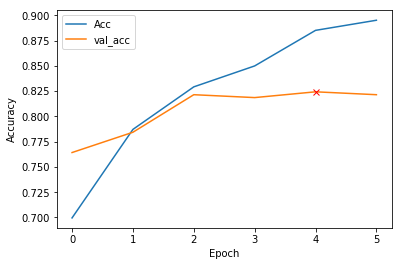

In [30]:
accu=history.history['acc']
val_acc=history.history['val_acc']

plt.plot(accu,label="Accuracy")
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Acc','val_acc'])
plt.plot( np.argmax(history.history["val_acc"]), np.max(history.history["val_acc"]), marker="x", color="r", label="best model")
plt.show()

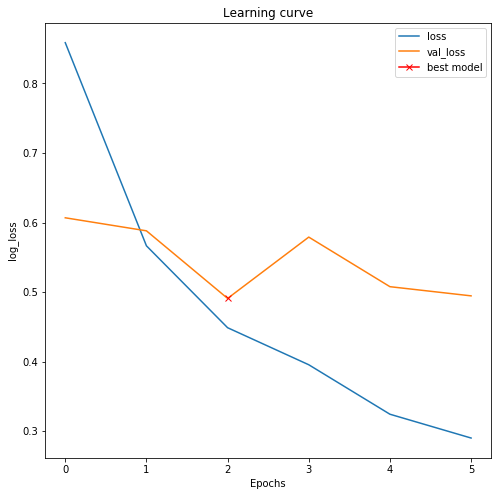

In [31]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [32]:
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
(eval_loss, eval_accuracy)=tqdm(model_resnet.evaluate_generator(generator=valid_generator,steps=NUB_VALID_STEPS, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(generator=<keras_pre..., steps=22, use_multiprocessing=False)`
  
100%|██████████| 2/2 [00:00<00:00, 9269.18it/s]

[INFO] accuracy: 81.14%
[INFO] Loss: 0.5434582221508026


In [33]:
test_datagen=image.ImageDataGenerator(rescale=1./255,validation_split=0.2,horizontal_flip=True)

test_generator=test_datagen.flow_from_dataframe(dataframe=df_test,
                                                directory = "../input/aptos2019-blindness-detection/test_images/",
                                                x_col="id_code",
                                                target_size=(IMG_DIM, IMG_DIM),
                                                batch_size=1,
                                                shuffle=False, 
                                                class_mode=None, 
                                                seed=SEED)
# del df_test
print(df_test.shape[0])
# del train_datagen
# del traabsin_generator
gc.collect()

Found 1928 validated image filenames.
1928


5492

In [34]:
tta_steps = 10
preds_tta=[]
for i in tqdm(range(tta_steps)):
    test_generator.reset()
    preds = model_resnet.predict_generator(generator=test_generator,steps =ceil(df_test.shape[0]))
#     print('Before ', preds.shape)
    preds_tta.append(preds)
#     print(i,  len(preds_tta))

100%|██████████| 10/10 [13:11<00:00, 78.89s/it]


In [35]:
final_pred = np.mean(preds_tta, axis=0)
predicted_class_indices = np.argmax(final_pred, axis=1)
len(predicted_class_indices)

1928

In [36]:
results=pd.DataFrame({"id_code":test_generator.filenames, "diagnosis":predicted_class_indices})  
results.id_code=results.id_code.apply(lambda x: x[:-4])# results.head()
results.to_csv("submission.csv", index=False)

In [37]:
results

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,4
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,1
